In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import statsmodels.api as sm
# import statsmodels.stats.diagnostic as smd
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
# from yellowbrick.regressor import ResidualsPlot
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from scipy.stats import normaltest

import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn import tree

train_data = pd.read_csv("csv/train.csv",  encoding='latin-1')


# Arboles de decision

## árbol de regresión para predecir el precio de las casas usando todas las variables. 

In [24]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

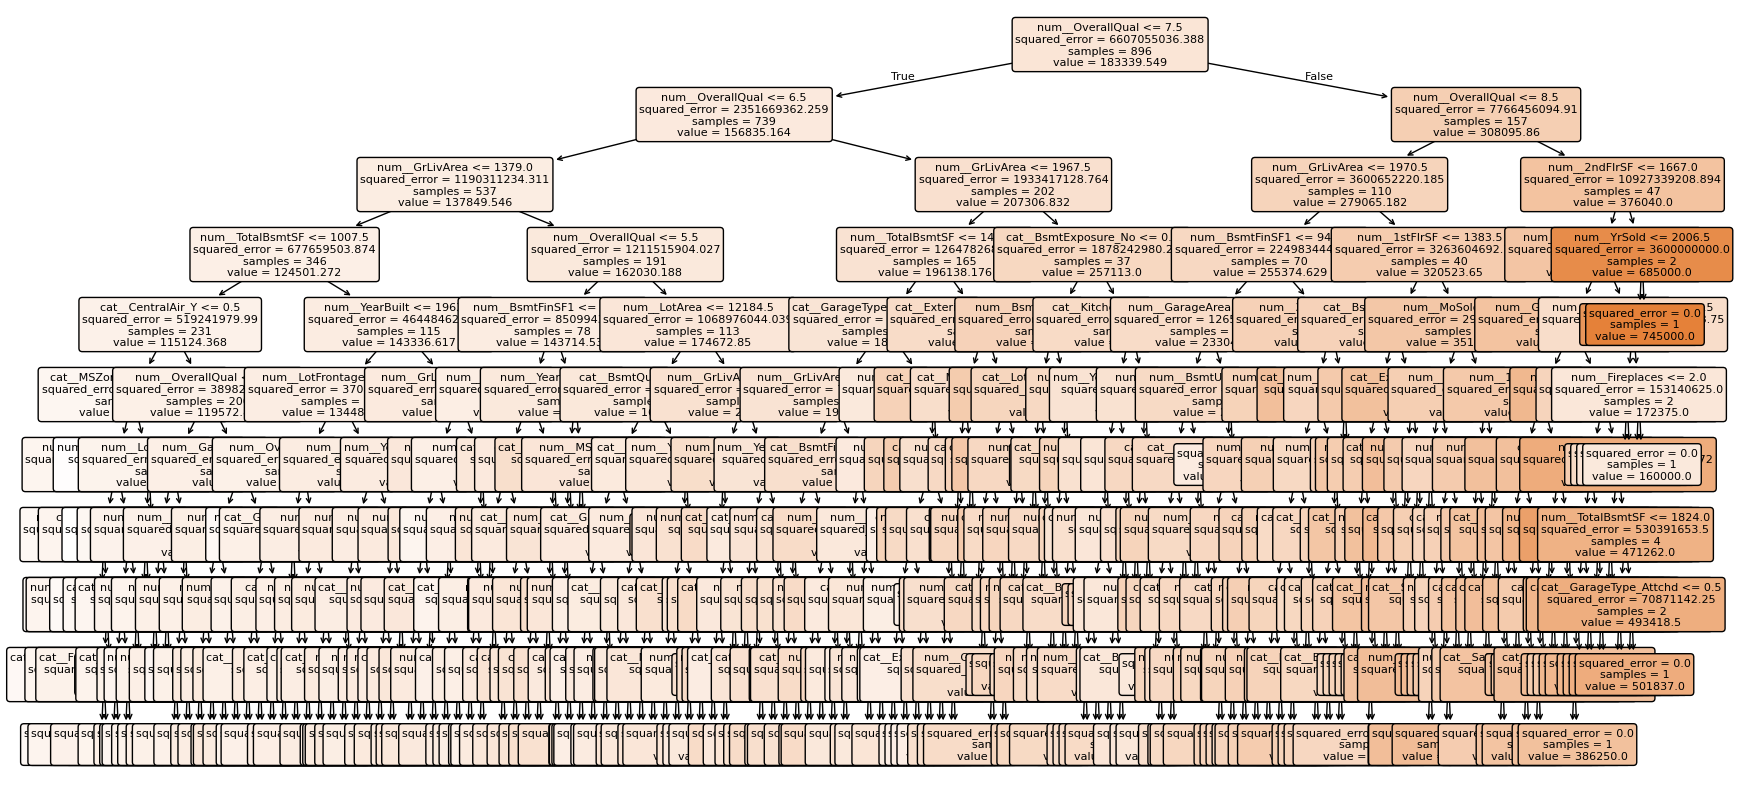

In [27]:
X_full = train_data.drop(columns=["Id", "SalePrice"])
y_full = train_data["SalePrice"] # (objetivo)

# Identificar columnas numéricas y categóricas

num_features = X_full.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_full.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),  # Pasar numéricas sin cambios
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # OneHot para categóricas
    ]
)

# Aplicar la transformación a los datos
X_transformed = preprocessor.fit_transform(X_full)

# Convertir el resultado a un DataFrame
if hasattr(X_transformed, "toarray"): 
    X_transformed = X_transformed.toarray()

X_transformed_df = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

# Eliminar filas con valores nulos
X_transformed_df = X_transformed_df.dropna()
y_filtered = y_full.loc[X_transformed_df.index]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y_filtered, test_size=0.2, random_state=42)

# Entrenar el árbol de regresión con todas las variables transformadas
reg_tree_full = DecisionTreeRegressor(max_depth=10, random_state=42)
reg_tree_full.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_full = reg_tree_full.predict(X_test)

# Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))
r2 = r2_score(y_test, y_pred_full)

# Mostrar métricas de evaluación
mae, rmse, r2

plt.figure(figsize=(20, 10))
tree.plot_tree(reg_tree_full, feature_names=preprocessor.get_feature_names_out(), filled=True, rounded=True, fontsize=8)
plt.show()


# 3 modelos más, cambiando el parámetro de la profundidad del árbol

[{'Depth': 4, 'MAE': 28620.02308279287, 'RMSE': np.float64(42030.71045976078), 'R²': 0.7760227297576276}, {'Depth': 6, 'MAE': 26487.921427493948, 'RMSE': np.float64(38951.39913977072), 'R²': 0.807639184516113}, {'Depth': 10, 'MAE': 26435.67571255905, 'RMSE': np.float64(39131.28632820905), 'R²': 0.8058583422254149}, {'Depth': 15, 'MAE': 27249.1706993007, 'RMSE': np.float64(39814.805158058436), 'R²': 0.7990168379633987}]


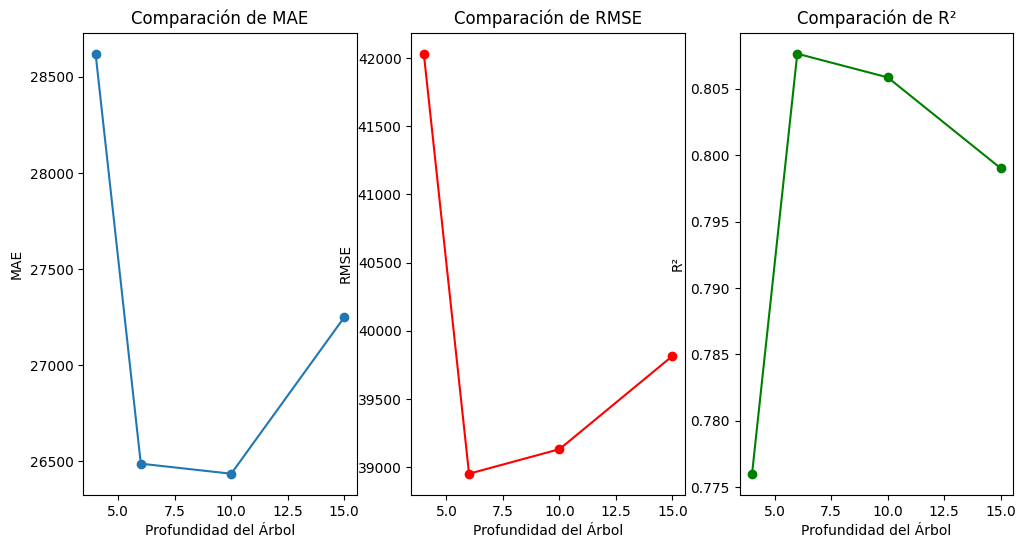

In [29]:
depths = [4, 6, 10, 15]  # Profundidades a evaluar
results = []

for depth in depths:
    # Entrenar el árbol de regresión con la profundidad actual
    reg_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    reg_tree.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = reg_tree.predict(X_test)

    # Evaluar el modelo
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    results.append({"Depth": depth, "MAE": mae, "RMSE": rmse, "R²": r2})

# Convertir resultados a DataFrame para visualización
results_df = pd.DataFrame(results)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Gráfico de MAE
plt.subplot(1, 3, 1)
plt.plot(results_df["Depth"], results_df["MAE"], marker='o', linestyle='-')
plt.xlabel("Profundidad del Árbol")
plt.ylabel("MAE")
plt.title("Comparación de MAE")

# Gráfico de RMSE
plt.subplot(1, 3, 2)
plt.plot(results_df["Depth"], results_df["RMSE"], marker='o', linestyle='-', color='r')
plt.xlabel("Profundidad del Árbol")
plt.ylabel("RMSE")
plt.title("Comparación de RMSE")

# Gráfico de R²
plt.subplot(1, 3, 3)
plt.plot(results_df["Depth"], results_df["R²"], marker='o', linestyle='-', color='g')
plt.xlabel("Profundidad del Árbol")
plt.ylabel("R²")
plt.title("Comparación de R²")
print(results)


- El MAE y el RMSE son más bajos en profundidad 6 y 10, lo que indica que estos modelos hacen predicciones más precisas. 
- El modelo con profundidad 6 tiene el mayor R² (0.808), lo que significa que explica mejor la variabilidad de los precios. 
- Aumentar la profundidad a 10 no mejora significativamente el R², lo que sugiere que no hay un gran beneficio en hacer el árbol más complejo.
- Con profundidad 15, el R² disminuye (0.799), lo que confirma que el modelo podría estar sobre ajustado y perdiendo capacidad de generalización. 
- El modelo con profundidad 6 es el más equilibrado. 

# Comparando arboles de regresion VS MRL de la hoja anterior

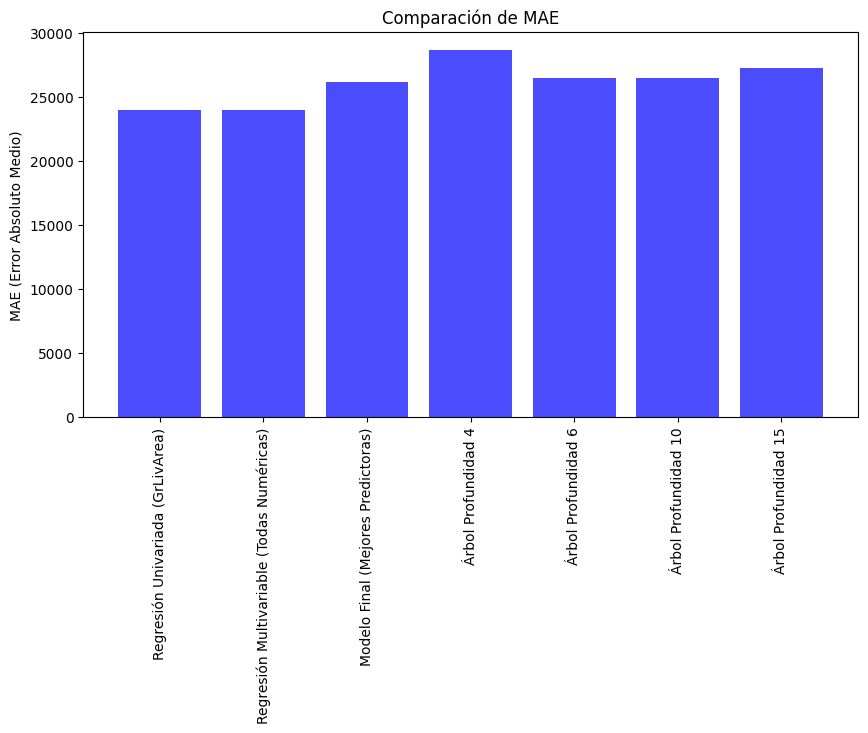

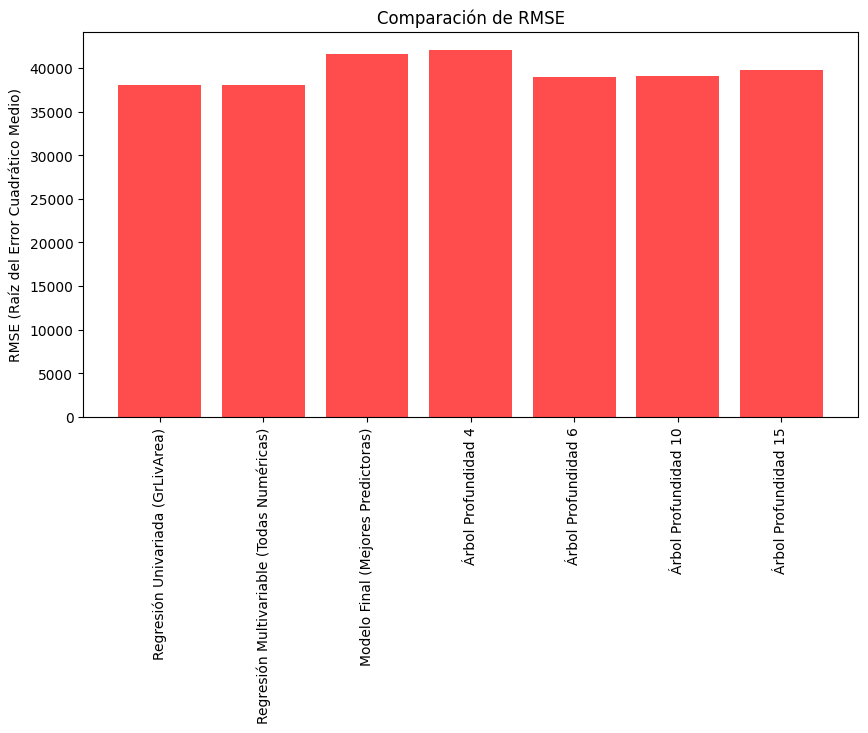

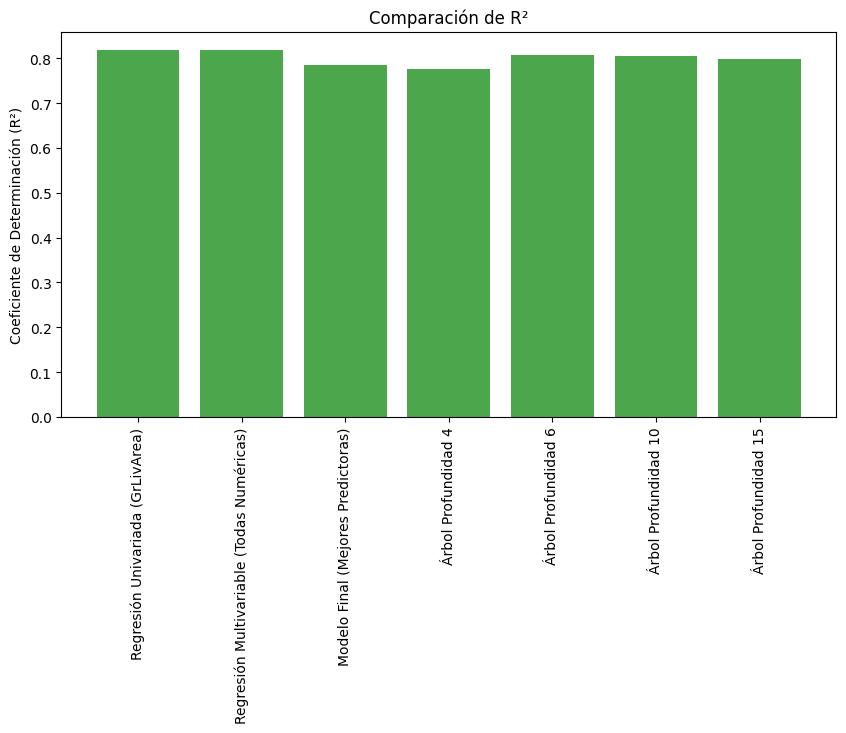

In [35]:
linear_models = pd.DataFrame({
    "Modelo": [
        "Regresión Univariada (GrLivArea)",
        "Regresión Multivariable (Todas Numéricas)",
        "Modelo Final (Mejores Predictoras)"
    ],
    "MAE": [23967.66, 23967.66, 26126.92],
    "RMSE": [38098.05, 38098.05, 41564.97],  # de regresion_lineal.ipynb
    "R²": [0.818, 0.818, 0.784]
})

tree_models = pd.DataFrame([
    {"Modelo": f"Árbol Profundidad {d['Depth']}", "MAE": d["MAE"], "RMSE": d["RMSE"], "R²": d["R²"]}
    for d in [
        {'Depth': 4, 'MAE': 28620.02, 'RMSE': 42030.71, 'R²': 0.776},
        {'Depth': 6, 'MAE': 26487.92, 'RMSE': 38951.40, 'R²': 0.808},
        {'Depth': 10, 'MAE': 26435.68, 'RMSE': 39131.29, 'R²': 0.806},
        {'Depth': 15, 'MAE': 27249.17, 'RMSE': 39814.81, 'R²': 0.799}
    ]
])

# Unir ambos conjuntos de modelos
all_models = pd.concat([linear_models, tree_models], ignore_index=True)

# Graficar comparación de MAE, RMSE y R²
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de MAE
plt.figure(figsize=(10, 5))
plt.bar(all_models["Modelo"], all_models["MAE"], color='blue', alpha=0.7)
plt.title("Comparación de MAE")
plt.ylabel("MAE (Error Absoluto Medio)")
plt.xticks(rotation=90)
plt.show()

# Gráfico de RMSE
plt.figure(figsize=(10, 5))
plt.bar(all_models["Modelo"], all_models["RMSE"], color='red', alpha=0.7)
plt.title("Comparación de RMSE")
plt.ylabel("RMSE (Raíz del Error Cuadrático Medio)")
plt.xticks(rotation=90)
plt.show()

# Gráfico de R²
plt.figure(figsize=(10, 5))
plt.bar(all_models["Modelo"], all_models["R²"], color='green', alpha=0.7)
plt.title("Comparación de R²")
plt.ylabel("Coeficiente de Determinación (R²)")
plt.xticks(rotation=90)
plt.show()


# Análisis de los resultados:

Regresión Lineal vs. Árbol de Decisión

- La regresión lineal multivariable (todas las variables numéricas) tuvo el mejor desempeño en términos de MAE y RMSE.
- La regresión univariada (solo GrLivArea) y la multivariable tienen el mejor R² (~0.818), lo que significa que explican más variabilidad en los precios de las casas.

## Conclusión: ¿Cuál modelo es mejor?
- La regresión lineal multivariable sigue siendo el mejor modelo en términos de precisión general.
- El árbol de decisión con profundidad 6 es la mejor alternativa dentro de los árboles de regresión,
